# Lie Detection
- We can increase the number of lies if we transcribe more speeches

In [209]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [210]:
# necessary files
clips = pd.read_csv('data-files/transcript_data_combined.csv')
clips['Transcript'] = clips['Transcript'].fillna('')
lies = pd.read_csv('data-files/all_speech_lies.csv')
lies["Lie Quote"] = lies["Lie Quote"].fillna('')
# only keep the lies contained in the first 4 speeches since we only have transcripts for the first 4 speeches
lies = lies[lies['Speech ID'].isin([1, 2, 3, 4])]

display(clips.head())
display(lies.head())
print(f'There are {len(lies)} lies in our dataset.')

,YouTube URL,Chunk Number,Chunk Filename,Transcript
0,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,1,/Users/milanvaghani/Desktop/Unstructed Machine...,
1,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,2,/Users/milanvaghani/Desktop/Unstructed Machine...,good evening everyone. Good evening good even...
2,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,3,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you thank you thank you thank you thank...
3,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,4,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you all thank you all okay we got to g...
4,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,5,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you everyone thank you everyone thank yo...


,Speech ID,Lie Quote
0,1,"His explicit intent to jail journalists, polit..."
1,1,we know and we know what a second Trump term w...
2,1,We're not going back to when Donald Trump trie...
3,1,We are not going to let him end programs like ...
4,1,"as president, I will bring together labor and ..."


There are 42 lies in our dataset.


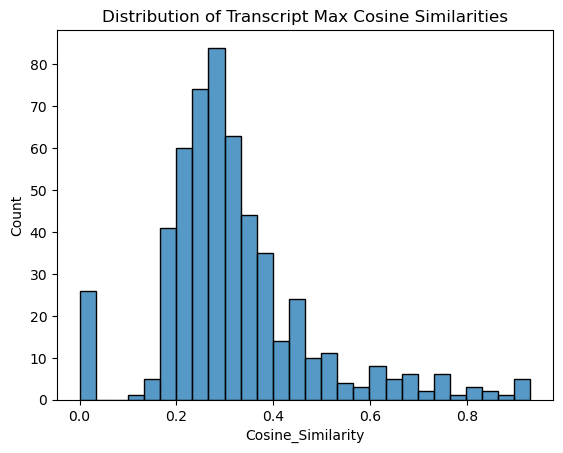

Number of clips identified as a lie for given threshold:


,threshold,clips labelled lie
0,0.20,464
1,0.25,374
2,0.30,246
3,0.35,158
4,0.40,104
5,0.45,79
6,0.50,57
7,0.55,43
8,0.60,37
9,0.65,28


43 clips are labelled as lies with a cosine similarity threshold of 0.55.


In [211]:
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(stop_words = 'english') # better to use this so we are paying attention to the key words

lie_vector = vectorizer.fit_transform(lies['Lie Quote'])

transcript_vector = vectorizer.transform(clips['Transcript'])

cosine_similarities = cosine_similarity(transcript_vector, lie_vector)

clips['Cosine_Similarity'] = cosine_similarities.max(axis=1)
max_similarity_indices = cosine_similarities.argmax(axis=1)
clips['Corresponding_Lie'] = lies['Lie Quote'].iloc[max_similarity_indices].values  # Get the corresponding lie


# testing thresh
sns.histplot(clips['Cosine_Similarity'])
plt.title('Distribution of Transcript Max Cosine Similarities')
plt.show()

cumsum = {}
for thresh in np.arange(.2,1,.05):
    cumsum[thresh] = (clips["Cosine_Similarity"] > thresh).sum()
print('Number of clips identified as a lie for given threshold:')
display(pd.Series(cumsum).reset_index().rename(columns = {'index':'threshold', 0:'clips labelled lie'}))

# setting thresh
thresh = .55
clips['lie'] = clips["Cosine_Similarity"] > thresh
n_lies = clips['lie'].sum()
print(f'{n_lies} clips are labelled as lies with a cosine similarity threshold of {thresh}.')

The number of unique lies detected is 32 in comparison to the total 42 in our dataset.


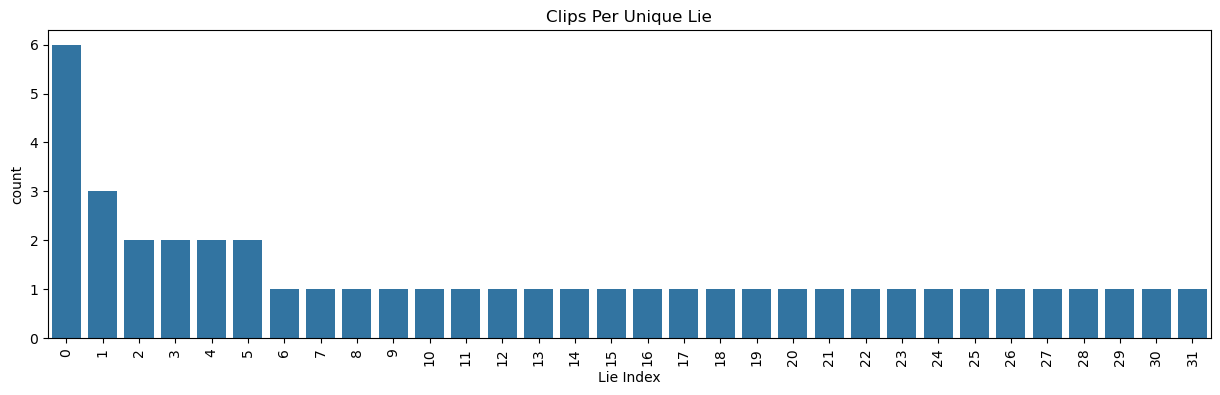

There are 26 with only one clip detected. We should check to make sure the clip detected is correct.
There are 6 lies with more than one clip detected.
I want to look at the clips for the lies that are being detected many times across different clips


In [212]:
# how many lies are captured by this threshold
n_unique_lies = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].nunique()
print(f'The number of unique lies detected is {n_unique_lies} in comparison to the total {len(lies)} in our dataset.')

# how often are the lies split up into multiple clips?
clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts()
clips_per_unique_lie = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts().reset_index()
plt.figure(figsize=(15,4))
sns.barplot(x=list(clips_per_unique_lie.index.values), y=clips_per_unique_lie['count'])
plt.xticks(rotation=90, fontsize=10)
plt.xlabel('Lie Index')
plt.title('Clips Per Unique Lie')
plt.show()
print(f'There are {(clips_per_unique_lie['count'] == 1).sum()} with only one clip detected. We should check to make sure the clip detected is correct.')
print(f'There are {(clips_per_unique_lie['count'] > 1).sum()} lies with more than one clip detected.')
print('I want to look at the clips for the lies that are being detected many times across different clips')

# Editing Lie Detection Output
The lie detection didn't work perfectly. Some lies present in the speeches weren't detected, and some lies that were detected had too many clips associated with them. We must:
1. Check to make sure the lies associated with a single clip are correct
2. Remove associations between a lie and a clip when they aren't actually associated
3. Manually mark clips for the remaining lies we weren't able to detect

## Lies with only 1 clip
These are right. Nothing needs to be done

In [213]:
# Lies with only 1 clip
lie_clip_counts = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts()
lies_with_one_clip = list(lie_clip_counts[lie_clip_counts == 1].index.values)
for lie in lies_with_one_clip:
    print(f'Lie "{lie}"')
    mask1 = clips['lie'] == True
    mask2 = clips['Corresponding_Lie'] == lie
    print(f'Corresponding clip: {clips.loc[(mask1 & mask2), 'Transcript'].values}')
    print('\n')

Lie "We have more liquid gold, oil and gas under our feet than any nation in the world, including Saudi Arabia and Russia"
Corresponding clip: ["are we getting them out we getting them out quickly and we will defeat inflation and we will make America affordable yet and it's going to start with liquid gold we have more Liquid Gold oil and gas under our feet than any nation in the world including Saudi Arabia and Russia we will become energy independent like we were just four years ago in a four years ago we were energy independent can you believe it and then we were going to become energy."]


Lie "has banned any and all ID requirements from voting and registering to vote"
Corresponding clip: ["doodle ID requirements from voting and registering to vote you're not even allowed to mention the fact they'll on you're not allowed to mention that that you can't say may I see your ID if you do it's a criminal act this is like this is a takeover of the country you're not allowed to ask for an I

## Lies with multiple clips

In [214]:
# lies with multiple clips
lie_clip_counts = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts()
lies_with_multiple_clips = list(lie_clip_counts[lie_clip_counts > 1].index.values)

for lie in lies_with_multiple_clips:
    print(f'Lie "{lie}"')
    mask1 = clips['lie'] == True
    mask2 = clips['Corresponding_Lie'] == lie
    print('Corresponding clips')
    for index, row in clips.loc[(mask1 & mask2), ['Cosine_Similarity', 'Transcript']].iterrows():
        print(f'Similarity = {row['Cosine_Similarity']}: {row['Transcript']}')
    print('\n')

Lie "because they’re sending their murderers to the United States of America."
Corresponding clips
Similarity = 0.5675169012394573: the United States of America  and what's that selection  and what type of election our nation
Similarity = 0.5996071154188681: especially after the United States Supreme Court just ruled that he would be immune from Criminal prosecution  just imagine Donald Trump with no guardrail  and how he would use the immense powers of the presidency of the United States
Similarity = 0.6616862495079034: for half of America  so tonight with faith and devotion I proudly accept your nomination for president of the United States thank you
Similarity = 0.6061445103145128: train murders to be wonderful people now because they're sending that murderers to the United States of America  is it going to be very bad  and bad things are going to happen and you seeing it happen all the time that's why to keep our family safe the Republican platform promises to launch the largest de

In [215]:
clips

,YouTube URL,Chunk Number,Chunk Filename,Transcript,Cosine_Similarity,Corresponding_Lie,lie
0,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,1,/Users/milanvaghani/Desktop/Unstructed Machine...,,0.000000,"His explicit intent to jail journalists, polit...",False
1,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,2,/Users/milanvaghani/Desktop/Unstructed Machine...,good evening everyone. Good evening good even...,0.485071,"A young lady from Italy, very good boxer, very...",False
2,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,3,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you thank you thank you thank you thank...,0.000000,"His explicit intent to jail journalists, polit...",False
3,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,4,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you all thank you all okay we got to g...,0.223324,"as president, I will bring together labor and ...",False
4,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,5,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you everyone thank you everyone thank yo...,0.331522,We are not going to let him end programs like ...,False
...,...,...,...,...,...,...,...
533,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,177,/Users/milanvaghani/Desktop/Unstructed Machine...,the Liberty Bell it's where the Army whether i...,0.309223,I love that chart. I love that graph. Isn't it...,False
534,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,178,/Users/milanvaghani/Desktop/Unstructed Machine...,this is the place where Pennsylvania Patriots ...,0.270602,I love that chart. I love that graph. Isn't it...,False
535,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,179,/Users/milanvaghani/Desktop/Unstructed Machine...,come our way no matter what obstacles we must ...,0.382062,because they’re sending their murderers to the...,False
536,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,180,/Users/milanvaghani/Desktop/Unstructed Machine...,we will make America healthy again we will ma...,0.464704,And we will end America's housing shortage.,False


In [216]:
# lie 1 ------------------------------------------------------
lie = "because they’re sending their murderers to the United States of America."
mask1 = clips['Corresponding_Lie'] == lie
# remove associations
false_clips = ["the United States of America  and what's that selection  and what type of election our nation",
               "especially after the United States Supreme Court just ruled that he would be immune from Criminal prosecution  just imagine Donald Trump with no guardrail  and how he would use the immense powers of the presidency of the United States",
              "for half of America  so tonight with faith and devotion I proudly accept your nomination for president of the United States thank you",
              "and quite simply put we will very quickly make America great again thank you very much thank you very much where is Constance God bless you  God bless you with Johnson and God bless the United States of America a great country thank you very much everybody thank you",
              "and I know we will I thank you all for inviting me may God bless you and may God bless the United States of America"
              ]
mask2 = clips['Transcript'].isin(false_clips)
print(f'I\'m removing the association between {len(clips.loc[mask1 & mask2, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask1 & mask2, 'lie'] = False
print('\n')

# lie 2 ------------------------------------------------------
lie = "would have never happened if I were president."
mask1 = clips['Corresponding_Lie'] == lie
# remove associations
false_clips = ["elections to the peaceful transfer of power  I will be a President Who unites us around our highest aspirations a president who leads and listen who is realistic practical and has come",
              "Olive asked me what happened tell us what happened please and therefore I will tell you exactly what happened and you'll never hear it from me a second time because it's actually too painful to tell  it was a warm beautiful day in the early evening in Butler Township in the great Commonwealth of Pennsylvania",
              ]
mask2 = clips['Transcript'].isin(false_clips)
print(f'I\'m removing the association between {len(clips.loc[mask1 & mask2, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask1 & mask2, 'lie'] = False

I'm removing the association between 5 clips and this lie:
 because they’re sending their murderers to the United States of America.


I'm removing the association between 2 clips and this lie:
 would have never happened if I were president.


## Lies not Captured
Must manually mark "True" in the clips df for at least one clip for each of these lies.

In [217]:
lies_captured = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].unique()
lies_not_captured = lies[~lies['Lie Quote'].isin(lies_captured)]
print(lies_not_captured['Lie Quote'].values)
print(len(lies_not_captured))

["And we will end America's housing shortage."
 "He doesn't actually fight for the middle class. Instead, he fights for himself and his billionaire friends. And he will give them another round of tax breaks that will add up to $5 trillion to the national debt."
 '88,000 agents' 'They spent $9 billion on eight chargers.'
 'They used COVID to cheat.'
 'When you look at the crime, look at the crime, look at the people that are coming in. Murderers, 13,099 murderers, let in over the last short period of time.'
 'cost you $29,000 a family through inflation, price hikes'
 'vowed to abolish ICE'
 'Donald Trump has no intention of lowering costs for the middle class'
 'Not everybody was handed on a silver platter, $400 million and then filed for bankruptcy six times.']
10


In [206]:
# lie 1
lie = "And we will end America's housing shortage."
# remove associations
true_clips = ["owners and entrepreneurs and Founders and we will end up America's housing shortage  Social Security and Medicare  now compare that to Donald Trump because I think everyone here knows he doesn't actually fight for the middle class not he doesn't actually fight for the middle class instead he fights for himself"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 2
lie = "He doesn't actually fight for the middle class. Instead, he fights for himself and his billionaire friends. And he will give them another round of tax breaks that will add up to $5 trillion to the national debt."
# remove associations
true_clips = ["owners and entrepreneurs and Founders and we will end up America's housing shortage  Social Security and Medicare  now compare that to Donald Trump because I think everyone here knows he doesn't actually fight for the middle class not he doesn't actually fight for the middle class instead he fights for himself",
             "his billionaire friends and he will give them another round of tax breaks that will add up to 5 trillion dollars to the national debt  and all the while he intends to enact what in effect is a national sales tax call it a trump tax that would raise prices on middle-class families by almost $4,000 a year"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 3
lie = "They spent $9 billion on eight chargers.’"
# remove associations
true_clips = ["you look at some of the things that have been done and some of the things that we're going to do but AI needs tremendous literally twice the electricity that's available now in our country can you imagine but instead we're spending  places where they recharge electric cars they built 8 chargers at a certain location for the Midwest a charges for nine billion dollar",
             "think of them as a tank for filling up your gas think of it they spent 9 billion dollars on a charges three of which didn't work  and if you are going to do this all over our country this crazy electric Band-Aid you going to do this and by the way I'm all for electric they have their application but if somebody wants to buy a gas powered car gasoline-powered car or a high"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 4
lie = "They used COVID to cheat."
# remove associations
true_clips = ["with us and then we had that horrible horrible result that will never let happen again the election result would never going to let that happen again that use Cobra to cheat you never going to let it happen again  and they took off all the sanctions that they did everything possible for a rant and now Iran is very close to having a nuclear weapon which would have never happened this is a shame what what this Administration did damage that this Administration is done and I say it often"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 5
lie = "When you look at the crime, look at the crime, look at the people that are coming in. Murderers, 13,099 murderers, let in over the last short period of time.'"
# remove associations
true_clips = ["we will talk about it but and if we do it'll be the greatest achievement I think in the history of politics for all of us for this age cuz we're going to change our country around and fast way to do things that nobody thought were possible to we're going to do them fast so Pennsylvania's time to stand up for America and it time to save our country this is really about saving our country it's never been like this when you look at the crime look at the crime look at the people that are coming in",
             "13099 murders let it over the last short. Of time  murderers that have been  released from penitentiary prison jail release into our country crime rates all over the world are down they're taking their gang members and their criminals are taken their people in jail and they're releasing them into our country we can't have it you know we just can't have it how do you"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 6
lie = "cost you $29,000 a family through inflation, price hikes"
# remove associations
true_clips = ["done she let him 21 million illegal aliens from all over the world from prisons and jails and mental institution and insane asylums and their terrorist at record levels and levels would never seen before she cost you $29,000 a family through inflation price hikes and now she wants a larger text I can she wants to go to the largest tax hike in American history there's never been a tax site like what she's proposing she's going to raise your taxes"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 7
lie = "vowed to abolish ICE"
# remove associations
true_clips = ["nothing we can do about it that's what they they say there's nothing you know they tried him and you know what they tried it in Minnesota with our vice president and I was at work it out too well it was working out very well for the robbers of the criminals that's the only one that was working out well for Kamala Harris vowed to abolish ice you once mass at Missy and citizenship for illegal and worst of all she lost our this is baby the worst thing in the whole that nobody talks to fake news won't mention it she lost"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 8
lie = "Donald Trump has no intention of lowering costs for the middle class'"
# remove associations
true_clips = ["and kept the cost of prescription drugs for all Americans just like we did for our seniors  Now by contrast Donald Trump has no intention of luring cost for the middle class  in fact his economic agenda would actually raise prices and listen that's not just my opinion a survey of top Economist by the financial times and the University of Chicago"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

# lie 9
lie = "Not everybody was handed on a silver platter, $400 million and then filed for bankruptcy six times."
# remove associations
true_clips = ["let me have the willingness to take the risk but they don't have access to the capital that they need to make it real and if Andrea said not everybody was handed on a silver platter and a million dollars and then file bankruptcy 690 I said that  I actually said that  well we can make it easier we can make it easier for small businesses to add"]
mask = clips['Transcript'].isin(true_clips)
print(f'I\'m adding an association between {len(clips.loc[mask, 'lie'])} clips and this lie:\n {lie}')
clips.loc[mask, 'lie'] = True
clips.loc[mask, 'Corresponding_Lie'] = lie
print('\n')

I'm adding an association between 1 clips and this lie:
 And we will end America's housing shortage.


I'm adding an association between 2 clips and this lie:
 He doesn't actually fight for the middle class. Instead, he fights for himself and his billionaire friends. And he will give them another round of tax breaks that will add up to $5 trillion to the national debt.


I'm adding an association between 2 clips and this lie:
 They spent $9 billion on eight chargers.’


I'm adding an association between 1 clips and this lie:
 They used COVID to cheat.


I'm adding an association between 2 clips and this lie:
 When you look at the crime, look at the crime, look at the people that are coming in. Murderers, 13,099 murderers, let in over the last short period of time.'


I'm adding an association between 1 clips and this lie:
 cost you $29,000 a family through inflation, price hikes


I'm adding an association between 1 clips and this lie:
 vowed to abolish ICE


I'm adding an association 

# Final Check
We should be capturing 41 lies now (can't find one)

The number of unique lies detected is 39 in comparison to the total 42 in our dataset.


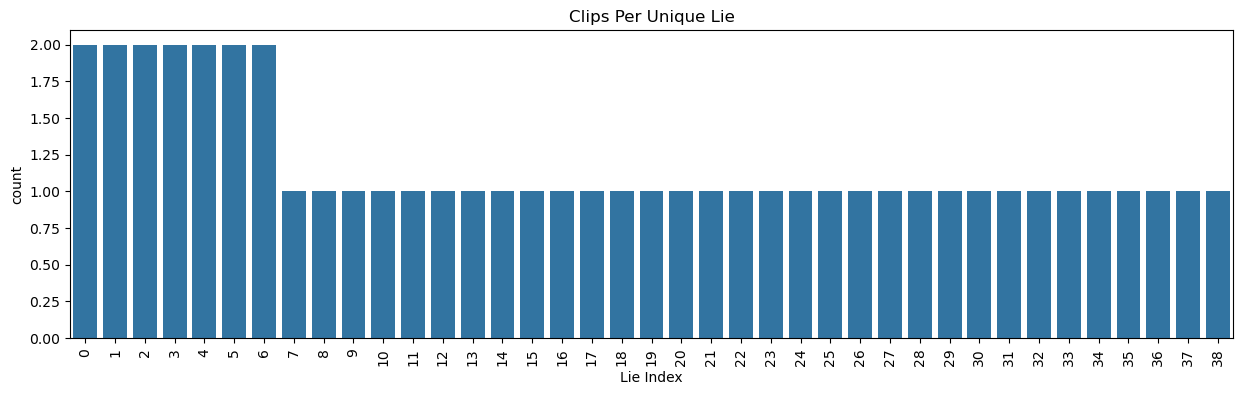

There are 32 with only one clip detected.
There are 7 lies with more than one clip detected.


In [207]:
# how many lies are captured by this threshold
n_unique_lies = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].nunique()
print(f'The number of unique lies detected is {n_unique_lies} in comparison to the total {len(lies)} in our dataset.')

# how often are the lies split up into multiple clips?
clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts()
clips_per_unique_lie = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].value_counts().reset_index()
plt.figure(figsize=(15,4))
sns.barplot(x=list(clips_per_unique_lie.index.values), y=clips_per_unique_lie['count'])
plt.xticks(rotation=90, fontsize=10)
plt.xlabel('Lie Index')
plt.title('Clips Per Unique Lie')
plt.show()
print(f'There are {(clips_per_unique_lie['count'] == 1).sum()} with only one clip detected.')
print(f'There are {(clips_per_unique_lie['count'] > 1).sum()} lies with more than one clip detected.')

In [208]:
lies_captured = clips.loc[clips['lie'] == True, 'Corresponding_Lie'].unique()
lies_not_captured = lies[~lies['Lie Quote'].isin(lies_captured)]
lies_not_captured['Lie Quote'].values

array(["And we will end America's housing shortage.",
       'And all the while he intends to enact what, in effect, is a national sales tax? Call it a Trump tax that would raise prices on middle class families by almost $4,000 a year.',
       '88,000 agents', 'They spent $9 billion on eight chargers.',
       'When you look at the crime, look at the crime, look at the people that are coming in. Murderers, 13,099 murderers, let in over the last short period of time.',
       'Donald Trump has no intention of lowering costs for the middle class'],
      dtype=object)

In [218]:
# only keep the columns we need
clips = clips[['YouTube URL', 'Chunk Number', 'Chunk Filename', 'Transcript', 'lie']]
display(clips)


,YouTube URL,Chunk Number,Chunk Filename,Transcript,lie
0,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,1,/Users/milanvaghani/Desktop/Unstructed Machine...,,False
1,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,2,/Users/milanvaghani/Desktop/Unstructed Machine...,good evening everyone. Good evening good even...,False
2,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,3,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you thank you thank you thank you thank...,False
3,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,4,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you all thank you all okay we got to g...,False
4,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,5,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you everyone thank you everyone thank yo...,False
...,...,...,...,...,...
533,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,177,/Users/milanvaghani/Desktop/Unstructed Machine...,the Liberty Bell it's where the Army whether i...,False
534,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,178,/Users/milanvaghani/Desktop/Unstructed Machine...,this is the place where Pennsylvania Patriots ...,False
535,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,179,/Users/milanvaghani/Desktop/Unstructed Machine...,come our way no matter what obstacles we must ...,False
536,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,180,/Users/milanvaghani/Desktop/Unstructed Machine...,we will make America healthy again we will ma...,False


In [219]:
clips.to_csv("data-files/transcripts_w_lies.csv")